In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# build the dataset (train, test, and validation)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [3]:
# can also start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


In [4]:
def evaluator(y_test, y_pred):
    import numpy as np

    # confusion matrix
    K = len(np.unique(y_test))
    confusion_matrix = np.zeros((K, K))

    for i in range(len(y_test)):
        confusion_matrix[y_test[i]][y_pred[i]] += 1
    
    # TP, FP, TN, FN
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # accuracy
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    
    # precision
    precision = TP / (TP+FP)
    
    # recall score
    recall_score = TP / (TP+FN)
    
    # F1 score
    F1_score = (2*precision*recall_score)/(precision + recall_score)

    return_list = []
    return_list.append(confusion_matrix)
    return_list.append(accuracy)
    return_list.append(precision)
    return_list.append(recall_score)
    return_list.append(F1_score)
    return return_list

#### Three-layer neural network (MLP) implemented in Pytorch
- Weights are updated with backpropagation.
- The three layers are: input layer, hidden layer, output layer.

In [5]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # activation function
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01  # hidden weights
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01  # output weights

        # train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                
                # forward and output
                hidden = self.sigmoid(torch.matmul(x_batch, self.W1))  # hidden layer output
                output = self.sigmoid(torch.matmul(hidden, self.W2))  # output layer output
                
                # calculating error and loss (output error, MSE loss, delta output and delta hidden)
                output_error = y_batch - output
                loss += torch.mean(torch.square(output_error))
                
                delta_output = output_error * output * (1 - output)
                delta_hidden = torch.matmul(delta_output, self.W2.T) * hidden * (1 - hidden)
                
                # updating weights with backpropagation
                self.W1 += self.learning_rate * torch.matmul(x_batch.T, delta_hidden)
                self.W2 += self.learning_rate * torch.matmul(hidden.T, delta_output)
                
            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc.cpu())
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc.cpu())
            if verbose:
                print('Epoch %d: loss %.4f, train accuracy %.3f, validation accuracy %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # prediction function 
    def predict(self, x):
        
        hidden = self.sigmoid(torch.matmul(x, self.W1))

        output = self.sigmoid(torch.matmul(hidden, self.W2))
        output = torch.argmax(output, dim=1)
        
        y_pred = output
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [6]:
# initializing and training the model

model1 = NN(learning_rate=0.01, n_iters=250, batch_size=100, hidden_size=200, device=device)

x_train = data_dict['x_train'].to(device)
y_train = data_dict['y_train'].to(device)
x_val = data_dict['x_val'].to(device)
y_val = data_dict['y_val'].to(device)

model1.train(x_train, y_train, x_val, y_val, verbose=1)

Epoch 1: loss nan, train accuracy 0.820, validation accuracy 0.839
Epoch 2: loss nan, train accuracy 0.886, validation accuracy 0.900
Epoch 3: loss nan, train accuracy 0.900, validation accuracy 0.912
Epoch 4: loss nan, train accuracy 0.909, validation accuracy 0.919
Epoch 5: loss nan, train accuracy 0.916, validation accuracy 0.924
Epoch 6: loss nan, train accuracy 0.921, validation accuracy 0.928
Epoch 7: loss nan, train accuracy 0.926, validation accuracy 0.932
Epoch 8: loss nan, train accuracy 0.929, validation accuracy 0.936
Epoch 9: loss nan, train accuracy 0.933, validation accuracy 0.940
Epoch 10: loss nan, train accuracy 0.936, validation accuracy 0.942
Epoch 11: loss nan, train accuracy 0.938, validation accuracy 0.944
Epoch 12: loss nan, train accuracy 0.941, validation accuracy 0.947
Epoch 13: loss nan, train accuracy 0.944, validation accuracy 0.948
Epoch 14: loss nan, train accuracy 0.946, validation accuracy 0.950
Epoch 15: loss nan, train accuracy 0.948, validation accu

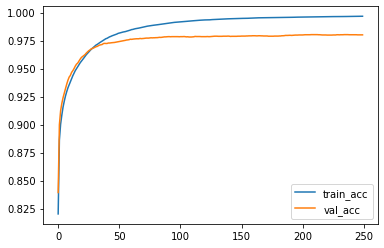

In [7]:
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [8]:
# evaluating the model with the test set

y_pred1 = model1.predict(data_dict['x_test'].to(device)).cpu()
eval_list1 = evaluator(data_dict['y_test'].argmax(dim=1), y_pred1)

print("The confusion matrix: ")
print(eval_list1[0])

print("The accuracy: ")
print(eval_list1[1])

print("The precision: ")
print(eval_list1[2])

print("The recall score: ")
print(eval_list1[3])

print("The F1 score: ")
print(eval_list1[4])

The confusion matrix: 
[[9.720e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00
  1.000e+00 1.000e+00 2.000e+00]
 [0.000e+00 1.128e+03 1.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00
  1.000e+00 1.000e+00 0.000e+00]
 [4.000e+00 1.000e+00 1.012e+03 0.000e+00 3.000e+00 0.000e+00 2.000e+00
  6.000e+00 4.000e+00 0.000e+00]
 [1.000e+00 0.000e+00 4.000e+00 9.920e+02 0.000e+00 4.000e+00 0.000e+00
  2.000e+00 4.000e+00 3.000e+00]
 [0.000e+00 0.000e+00 3.000e+00 1.000e+00 9.640e+02 0.000e+00 4.000e+00
  1.000e+00 0.000e+00 9.000e+00]
 [4.000e+00 0.000e+00 1.000e+00 6.000e+00 1.000e+00 8.730e+02 2.000e+00
  1.000e+00 3.000e+00 1.000e+00]
 [7.000e+00 2.000e+00 2.000e+00 1.000e+00 1.000e+00 2.000e+00 9.380e+02
  1.000e+00 4.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 8.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.007e+03 3.000e+00 4.000e+00]
 [3.000e+00 0.000e+00 5.000e+00 3.000e+00 4.000e+00 1.000e+00 2.000e+00
  4.000e+00 9.490e+02 3.000e+00]
 [4.000e+00 3.000e+00 0.000e+00 

#### Three-layer neural network (MLP) implemented in Sci-kit learn

In [9]:
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

# implementing model2 with sklearn
model2 = MLPClassifier(hidden_layer_sizes=(100), activation='logistic', solver='adam', max_iter=250, verbose=1)

In [10]:
# training model2 with sklearn
model2.fit(data_dict['x_train'], data_dict['y_train'].argmax(axis=1))

Iteration 1, loss = 0.93329955
Iteration 2, loss = 0.36412813
Iteration 3, loss = 0.28362199
Iteration 4, loss = 0.24321725
Iteration 5, loss = 0.21506335
Iteration 6, loss = 0.19267279
Iteration 7, loss = 0.17533155
Iteration 8, loss = 0.15973232
Iteration 9, loss = 0.14683544
Iteration 10, loss = 0.13531226
Iteration 11, loss = 0.12497747
Iteration 12, loss = 0.11587047
Iteration 13, loss = 0.10789654
Iteration 14, loss = 0.10017591
Iteration 15, loss = 0.09339116
Iteration 16, loss = 0.08738625
Iteration 17, loss = 0.08157068
Iteration 18, loss = 0.07635221
Iteration 19, loss = 0.07156179
Iteration 20, loss = 0.06698623
Iteration 21, loss = 0.06299459
Iteration 22, loss = 0.05916851
Iteration 23, loss = 0.05554479
Iteration 24, loss = 0.05215727
Iteration 25, loss = 0.04938862
Iteration 26, loss = 0.04628584
Iteration 27, loss = 0.04358380
Iteration 28, loss = 0.04118934
Iteration 29, loss = 0.03866996
Iteration 30, loss = 0.03652719
Iteration 31, loss = 0.03460378
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=100, max_iter=250,
              verbose=1)

In [11]:
# evaluating model2 with sklearn

y_pred2 = model2.predict(data_dict['x_test'])
eval_list2 = evaluator(data_dict['y_test'].argmax(dim=1), y_pred2)

print("The confusion matrix: ")
print(eval_list2[0])

print("The accuracy: ")
print(eval_list2[1])

print("The precision: ")
print(eval_list2[2])

print("The recall score: ")
print(eval_list2[3])

print("The F1 score: ")
print(eval_list2[4])

The confusion matrix: 
[[9.680e+02 0.000e+00 0.000e+00 1.000e+00 2.000e+00 2.000e+00 5.000e+00
  1.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.126e+03 3.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00
  1.000e+00 1.000e+00 0.000e+00]
 [4.000e+00 2.000e+00 1.009e+03 1.000e+00 1.000e+00 1.000e+00 5.000e+00
  4.000e+00 4.000e+00 1.000e+00]
 [1.000e+00 1.000e+00 3.000e+00 9.880e+02 2.000e+00 4.000e+00 0.000e+00
  4.000e+00 1.000e+00 6.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 1.000e+00 9.590e+02 0.000e+00 5.000e+00
  0.000e+00 2.000e+00 1.400e+01]
 [3.000e+00 0.000e+00 0.000e+00 1.200e+01 0.000e+00 8.620e+02 6.000e+00
  3.000e+00 5.000e+00 1.000e+00]
 [5.000e+00 3.000e+00 1.000e+00 0.000e+00 1.000e+00 4.000e+00 9.420e+02
  0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 1.200e+01 2.000e+00 1.000e+00 1.000e+00 0.000e+00
  1.001e+03 2.000e+00 6.000e+00]
 [4.000e+00 0.000e+00 5.000e+00 7.000e+00 5.000e+00 5.000e+00 3.000e+00
  4.000e+00 9.370e+02 4.000e+00]
 [2.000e+00 3.000e+00 0.000e+00 

#### Four-layer neural network (MLP) implemented in Sci-kit learn
- The four layers are: input layer, hidden layer 1, hidden layer 2, output layer.

In [12]:
# implementing model3 with sklearn
model3 = MLPClassifier(hidden_layer_sizes=(100,100), activation='logistic', solver='adam', max_iter=250, verbose=1)

# by using the parameter hidden_layer_sizes=(100,100), this will set mlp2 to have 2 hidden layers with 100 nodes
# for each hidden layer. The size of the tuple given to hidden_layer_sizes determines the amount of hidden layers
# that mlp2 will have
# Ex: you can create an mlp with one hidden layer with hidden_layer_sizes=(100)
# Ex: you can create an mlp with three hidden layers with hidden_layer_sizes=(100,100,100)

In [13]:
# training model3 with sklearn
model3.fit(data_dict['x_train'], data_dict['y_train'].argmax(axis=1))

Iteration 1, loss = 1.22409306
Iteration 2, loss = 0.37707684
Iteration 3, loss = 0.26708982
Iteration 4, loss = 0.21825267
Iteration 5, loss = 0.18446071
Iteration 6, loss = 0.15843306
Iteration 7, loss = 0.13806440
Iteration 8, loss = 0.12149575
Iteration 9, loss = 0.10790292
Iteration 10, loss = 0.09644608
Iteration 11, loss = 0.08617191
Iteration 12, loss = 0.07782718
Iteration 13, loss = 0.06979020
Iteration 14, loss = 0.06371662
Iteration 15, loss = 0.05743872
Iteration 16, loss = 0.05159323
Iteration 17, loss = 0.04610122
Iteration 18, loss = 0.04184633
Iteration 19, loss = 0.03785800
Iteration 20, loss = 0.03369530
Iteration 21, loss = 0.03039631
Iteration 22, loss = 0.02727273
Iteration 23, loss = 0.02493177
Iteration 24, loss = 0.02225037
Iteration 25, loss = 0.01980550
Iteration 26, loss = 0.01774288
Iteration 27, loss = 0.01592988
Iteration 28, loss = 0.01416793
Iteration 29, loss = 0.01273428
Iteration 30, loss = 0.01137625
Iteration 31, loss = 0.00997406
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              max_iter=250, verbose=1)

In [14]:
# evaluating model3 with sklearn

y_pred3 = model3.predict(data_dict['x_test'])
eval_list3 = evaluator(data_dict['y_test'].argmax(dim=1), y_pred3)

print("The confusion matrix: ")
print(eval_list3[0])

print("The accuracy: ")
print(eval_list3[1])

print("The precision: ")
print(eval_list3[2])

print("The recall score: ")
print(eval_list3[3])

print("The F1 score: ")
print(eval_list3[4])

The confusion matrix: 
[[9.700e+02 0.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 2.000e+00
  2.000e+00 1.000e+00 1.000e+00]
 [0.000e+00 1.125e+03 2.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.000e+00 3.000e+00 0.000e+00]
 [5.000e+00 2.000e+00 1.008e+03 4.000e+00 1.000e+00 0.000e+00 2.000e+00
  4.000e+00 6.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 6.000e+00 9.830e+02 0.000e+00 5.000e+00 0.000e+00
  6.000e+00 5.000e+00 3.000e+00]
 [1.000e+00 0.000e+00 3.000e+00 1.000e+00 9.630e+02 0.000e+00 2.000e+00
  1.000e+00 1.000e+00 1.000e+01]
 [5.000e+00 0.000e+00 0.000e+00 1.200e+01 1.000e+00 8.610e+02 5.000e+00
  1.000e+00 4.000e+00 3.000e+00]
 [4.000e+00 2.000e+00 5.000e+00 1.000e+00 2.000e+00 4.000e+00 9.380e+02
  0.000e+00 2.000e+00 0.000e+00]
 [1.000e+00 4.000e+00 6.000e+00 4.000e+00 1.000e+00 0.000e+00 0.000e+00
  9.990e+02 3.000e+00 1.000e+01]
 [4.000e+00 0.000e+00 4.000e+00 5.000e+00 3.000e+00 4.000e+00 5.000e+00
  5.000e+00 9.430e+02 1.000e+00]
 [3.000e+00 3.000e+00 0.000e+00 